# Start


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from typing import Optional


file_path: str = "../dataset"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")

-   importing the necessary libraries
-   declaring the variables


# A.)


### Connections description


In [ ]:
dataset["connections"].info()

-   Total Entries: 15,108
-   Total Columns: 13
-   Column Types:
-   11 columns of type float64
-   1 column of type int64
-   1 column of type object
-   There are no missing values in this data


In [ ]:
dataset["connections"]["ts"]

-   The object column "ts" is date and time


In [ ]:
connection_summary = dataset["connections"].describe()
median = (
    dataset["connections"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
connection_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
connection_summary.drop(columns=["imei"], inplace=True)
connection_summary

-   From these tables above we can see imei is a long integer and looks like an Id, if we look at processes table, we can also see same values indicating this could be an Id of device.
-   Another assumption we can make is that columns specifying a connection type (columns starting with c. such as c.android.youtube) have values ranging from 0 to 100, this could indicate that it is a percentage amount of time that the connection was established.


-   First few rows might indicate that the data was sample in a 1 minute interval.
-   Let's look at it closer.


In [ ]:
dataset["connections"].sort_values(by="ts", ascending=True)["ts"]

-   Now we see it looks like samples are in a 1 minute interval.
-   Let's go further.


In [ ]:
times = dataset["connections"].sort_values(by="ts")["ts"]
times = pd.to_datetime(times)

previous_time: Optional[pd.Series] = None

same_times: int = 0
non_minute_differences: int = 0


for current_time in times:
    if previous_time is None:
        previous_time = current_time
        continue

    if (current_time - previous_time).seconds == 0:
        same_times += 1

    elif (current_time - previous_time).seconds != 60:
        non_minute_differences += 1

    previous_time = current_time

print(f"Non minute differences: {non_minute_differences}")
print(f"Same times: {same_times}")

-   From this we can see, that there are data every minute, sometimes more than once at the same time.


In [ ]:
times = (
    dataset["connections"]
    .groupby(by="imei")[["imei", "ts"]]
    .apply(lambda x: x.sort_values(by="ts", ascending=True))
    .reset_index(drop=True)
)
times

-   If we assume that columns starting with "c." are representing percentage amount of time being active during a time window, we need to group them by device serial number (imei) and then look at the time difference.


In [ ]:
dataset["connections"]["mwra"].value_counts()

-   mwra is (Malware-related-activity)
-   In data there are only values 1.0 and 0.0 indicating if there was a malware activity in specific time frame.


### Devices description


In [ ]:
dataset["devices"].info()

In [ ]:
devices_summary = dataset["devices"].describe()
median = (
    dataset["devices"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
devices_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
devices_summary.drop(columns=["imei"], inplace=True)
devices_summary

In [ ]:
dataset["devices"].head()

-   "store_name" object is a string
-   "code" is string, holding code for state
-   "location" is a string, containing continent and city


### Processes description


In [ ]:
dataset["processes"].info()

In [ ]:
processes_summary = dataset["processes"].describe()
median = (
    dataset["processes"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
processes_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
processes_summary.drop(columns=["imei"], inplace=True)
processes_summary

In [ ]:
dataset["processes"].head()

### Profiles description


In [ ]:
dataset["profiles"].info()

In [ ]:
profiles_summary = dataset["profiles"].describe()
median = (
    dataset["profiles"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
profiles_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
profiles_summary.drop(columns=["imei"], inplace=True)
profiles_summary

In [ ]:
dataset["profiles"].head()

In [ ]:
null_values = {file: data.isnull().sum() for file, data in dataset.items()}
for file, nulls in null_values.items():
    if nulls.sum() == 0:
        continue
    print(f"Null values in {file} dataset:")
    print(nulls)
    print("\n")

# B.)


### MWRA


-   First we look at the most important column "mwra" and look at it more in depth.


In [ ]:
dataset["connections"]["mwra"].value_counts(normalize=True) * 100

-   In "connections" we can see that positive mwra is ~62%, indicating that there are more positive cases and therefore in future when we put it into our model might falsely evaluate some connections. I would say the closer we are to 50/50 the better.


In [ ]:
dataset["processes"]["mwra"].value_counts(normalize=True) * 100

-   "mwra" is the same for "processes" as it is for "connections"


### Declaring and Initializing variables for further use.


In [21]:
chrome_data = dataset["connections"]["c.android.chrome"]
chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

dogalize_data = dataset["connections"]["c.dogalize"]
dogalize_mean = dogalize_data.mean()
dogalize_std = dogalize_data.std()

gm_data = dataset["connections"]["c.android.gm"]
gm_mean = gm_data.mean()
gm_std = gm_data.std()

youtube_data = dataset["connections"]["c.android.youtube"]
youtube_mean = youtube_data.mean()
youtube_std = youtube_data.std()

katana_data = dataset["connections"]["c.katana"]
katana_mean = katana_data.mean()
katana_std = katana_data.std()

raider_data = dataset["connections"]["c.raider"]
raider_mean = raider_data.mean()
raider_std = raider_data.std()

vending_data = dataset["connections"]["c.android.vending"]
vending_mean = vending_data.mean()
vending_std = vending_data.std()

x86_data = dataset["connections"]["c.UCMobile.x86"]
x86_mean = x86_data.mean()
x86_std = x86_data.std()


updateassist_data = dataset["connections"]["c.updateassist"]
updateassist_mean = updateassist_data.mean()
updateassist_std = updateassist_data.std()

intl_data = dataset["connections"]["c.UCMobile.intl"]
intl_mean = intl_data.mean()
intl_std = intl_data.std()

In [ ]:
chrome_data.value_counts()

In [ ]:
stats.mode(chrome_data)

### c.android.chrome


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))


# Plot the histogram and KDE for the data
sns.histplot(chrome_data, bins=30, kde="True", label="c.android.chrome")
plt.axvline(chrome_mean, color="red", linestyle="--", label=f"Mean: {chrome_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right.
-   We can see that the type is gaussian, but not a perfect one, but still good.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=chrome_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=chrome_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(chrome_data.min(), chrome_data.max(), 100)
gaussian = stats.norm.pdf(x, chrome_mean, chrome_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.chrome Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that "c.android.chrome" is gaussian, but not perfect, little bit lower and skewed to the right.


In [ ]:
chrome_skew = stats.skew(chrome_data)
print(f"Skewness of c.android.chrome: {chrome_skew}")

-   Skewness is 0.20270904314934854, therefore this data is approximately symmetric, but has a little bit fatter right tail.
-   We already saw that the data is skewed to the right, so this is just a confirmation.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=chrome_data)

# Customizing the plot
plt.title("Boxplot of c.android.chrome")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We see little outliers in the data at lower values, but quite a bit at higher values.


If we assume the values in columns are active time, we could also look at the range 0-100


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(chrome_data, bins=30, kde=True)
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")

# Customizing the plot
plt.xlim(0, 100)
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.grid(True, alpha=0.3)
plt.show()

-   Here we see that there are little outliers in lower values, but there are quite few of them near maximum value.
-   This doesn't really help us, but it is interesting to see.


### c.dogalize


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(dogalize_data, bins=30, kde=True)
plt.axvline(dogalize_mean, color="r", linestyle="--", label=f"Mean: {dogalize_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.dogalize")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right, but very little.
-   We can see that the type is gaussian, almost perfect.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=dogalize_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=dogalize_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(dogalize_data.min(), dogalize_data.max(), 100)
gaussian = stats.norm.pdf(x, dogalize_mean, dogalize_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.dogalize Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We see that "c.dogalize" is gaussian, very close to perfect, just very little skewed to the right.


In [ ]:
dogalize_skew = stats.skew(dogalize_data)
print(f"Skewness of c.dogalize: {dogalize_skew}")

-   We can see that the data is almost symmetric, but has a little bit fatter right tail.
-   Interesting thing to see is that compared to "c.android.chrome" the skew is bigger, which indicates that the data is more assymetric. But on graph it looks better than "c.android.chrome". It looks better because it is not smaller, but just skewed.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=dogalize_data)

# Customizing the plot
plt.title("Boxplot of c.dogalize")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We see little outliers in the data at lower values, but quite a lot at higher values.
-   We also see more outliers than in "c.android.chrome".


### c.android.gm


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(gm_data, bins=30, kde=True)
plt.axvline(gm_mean, color="r", linestyle="--", label=f"Mean: {gm_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.gm")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right, but it can be kinda harder to see. So we will also make sure in later part.
-   We can see that the type is gaussian, but not a perfect one, as it has kinda chipped peak.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=gm_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=gm_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(gm_data.min(), gm_data.max(), 100)
gaussian = stats.norm.pdf(x, gm_mean, gm_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.gm Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   This is a confirmation that the data is skewed to the right, as we can see comparison to gaussian model.
-   We also see the chipped peak more clearly.


In [ ]:
gm_skew = stats.skew(gm_data)
print(f"Skewness of c.android.gm: {gm_skew}")

-   Here we see our confirmation that the data is skewed to the right, as we can see the skewness is 0.1450922533767856. Which is very close to 0, therefore the data is almost symmetric, but has a little bit fatter right tail.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=gm_data)

# Customizing the plot
plt.title("Boxplot of c.android.gm")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We again see little outliers at lower values. But we see quite a lot of them at higher values.
-   We also see that the range at the higher values where outliers reside is wider that in our previous graphs.


### c.android.youtube


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(youtube_data, bins=30, kde=True)
plt.axvline(youtube_mean, color="r", linestyle="--", label=f"Mean: {youtube_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.youtube")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here we can clearly see negative skew of graph.
-   We can see that the type is gaussian type.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=youtube_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=youtube_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(youtube_data.min(), youtube_data.max(), 100)
gaussian = stats.norm.pdf(x, youtube_mean, youtube_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.youtube Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the data is skewed to the left, as we can see the comparison to gaussian model.
-   Also peak is higher than gaussian model, indicating less variety in data.


In [ ]:
youtube_skew = stats.skew(youtube_data)
print(f"Skewness of c.android.youtube: {youtube_skew}")

-   the skewness of -0.6176239949793928 indicates that the data is moderately skewed to the left.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=youtube_data)

# Customizing the plot
plt.title("Boxplot of c.android.youtube")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   As ve look at outliers, we can see there are a lot of them, way more than our previous graphs. One reason is because the peak of graph is higher, so the range of outliers is wider.
-   In contrast to our previous graphs, we have more outliers at lower values than at higher values. This ve can also see in graph as it is skewed to the left.


### c.katana


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(katana_data, bins=30, kde=True)
plt.axvline(katana_mean, color="r", linestyle="--", label=f"Mean: {katana_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.katana")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right.
-   We can see that the type is gaussian type.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=katana_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=katana_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(katana_data.min(), katana_data.max(), 100)
gaussian = stats.norm.pdf(x, katana_mean, katana_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.katana Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We can also clearly see the skewness to the right.
-   We can also say that it is guite good gaussian type, but not perfect.


In [ ]:
katana_skew = stats.skew(katana_data)
print(f"Skewness of c.katana: {katana_skew}")

-   The skewness of 0.2101258113220123 indicates that the data is approximately symmetric, but has a little bit fatter right tail.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=katana_data)

# Customizing the plot
plt.title("Boxplot of c.katana")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   As we look at outliers, we again see little outliers at lower values, but quite a lot at higher values.
-   The number of outliers on low/high values is also the same as you would except when you would see a skewed graph to the right.


### c.raider


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(raider_data, bins=30, kde=True)
plt.axvline(raider_mean, color="r", linestyle="--", label=f"Mean: {raider_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.raider")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here se can see that the graph is skewed to the left, but very little.
-   It looks like it will be very good, almost perfect gaussian type, with probably skewness of more than -0.1 (less than 0.1).


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=raider_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=raider_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(raider_data.min(), raider_data.max(), 100)
gaussian = stats.norm.pdf(x, raider_mean, raider_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.raider Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   When we compare the graph to gaussian model, we can see that it is almost perfect


In [ ]:
raider_skew = stats.skew(raider_data)
print(f"Skewness of c.raider: {raider_skew}")

-   The skewness of -0.023361966464245734 indicates that the data is almost perfectly symmetric. I think we could also say that the data is symmetric as the skewness is very close to 0.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=raider_data)

# Customizing the plot
plt.title("Boxplot of c.raider")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   From deduction of above graphs (not boxplot), we could already say that there are gonna be very similar number of outliers at low/high values as data is almost perfectly symmetric.
-   This boxplot also confirms our deduction, as we see almost the same number of outliers at low/high values.
-   Although the data is almost perfectly symmetric, there are a lot of outliers, at both low/high values.
-   The eye-catching outliers are 0 and 100.


### c.android.vending


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(vending_data, bins=30, kde=True)
plt.axvline(vending_mean, color="r", linestyle="--", label=f"Mean: {vending_mean:.2f}")

# Plot the histogram and KDE for the data
plt.title("Distribution of c.android.vending")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We now see a new type of graph, not a gaussian type, but a uniform type.
-   Since we can't clearly see the skewness, we will also look at it in the next part.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = vending_data.min()
b = vending_data.max()
x = np.linspace(a, b, vending_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=vending_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=vending_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   I think the KDE of our diagram is not that important at limit values(0,100), as it is a prediction of values, therefore the function goes to lower values at limit values.
-   The useful part of KDE is in when it reaches the uniform model and there we can see at which values there are a little bit more data and where a little bit less, which we could also see from histogram but this makes it even more clear.


In [ ]:
vending_skew = stats.skew(vending_data)
print(f"Skewness of c.android.vending: {vending_skew}")

-   The skewness of 0.015750448964052415 indicates that the data is almost perfectly symmetric.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=vending_data)

# Customizing the plot
plt.title("Boxplot of c.android.vending")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Logically, there are no outliers in uniform graph.


### c.UCMobile.x86


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(x86_data, bins=30, kde=True)
plt.axvline(x86_mean, color="r", linestyle="--", label=f"Mean: {x86_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.UCMobile.x86")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We again see the uniform type of graph.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = x86_data.min()
b = x86_data.max()
x = np.linspace(a, b, x86_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=x86_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=x86_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can really say anything new from this clearly, so we move further.


In [ ]:
x86_skew = stats.skew(x86_data)
print(f"Skewness of c.UCMobile.x86: {x86_skew}")

-   The skewness of 0.014363279518336651 indicates that the data is almost perfectly symmetric.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=x86_data)

# Customizing the plot
plt.title("Boxplot of c.UCMobile.x86")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Again, logically, there are no outliers in uniform graph.


### c.updateassist


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(updateassist_data, bins=30, kde=True)
plt.axvline(updateassist_mean, color="r", linestyle="--", label=f"Mean: {updateassist_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.updateassist")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We again see uniform type of graph.
-   We can already see that limit values are a little bit higher than middle.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = updateassist_data.min()
b = updateassist_data.max()
x = np.linspace(a, b, updateassist_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=updateassist_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=updateassist_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here we see the difference between the middle and limit values, which is not that big, but still visible.


In [ ]:
updateassist_skew = stats.skew(updateassist_data)
print(f"Skewness of c.updateassist: {updateassist_skew}")

-   The skewness of 0.008035690970213479, the closes value to 0 we had to this point, indicates that the data is almost perfectly symmetric.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=updateassist_data)

# Customizing the plot
plt.title("Boxplot of c.updateassist")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Again, logically, there are no outliers in uniform graph.


### c.UCMobile.intl


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(intl_data, bins=30, kde=True)
plt.axvline(intl_mean, color="r", linestyle="--", label=f"Mean: {intl_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.UCMobile.intl")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We again see uniform type of graph.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = intl_data.min()
b = intl_data.max()
x = np.linspace(a, b, intl_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=intl_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=intl_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We see that the KDE is almost perfect with our uniform model, except of one small peak and small valley.


In [ ]:
intl_skew = stats.skew(intl_data)
print(f"Skewness of c.UCMobile.intl: {intl_skew}")

-   The skewness of 0.005795223191764485, even closer to 0 as our previous one, indicates that the data is almost perfectly symmetric.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=intl_data)

# Customizing the plot
plt.title("Boxplot of c.UCMobile.intl")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Again, logically, there are no outliers in uniform graph.


# Test


In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(16, 26))

# Chrome Data
sns.histplot(chrome_data, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")
axes[0, 0].set_title("Distribution of c.android.chrome")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dogalize Data
sns.histplot(dogalize_data, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].axvline(dogalize_mean, color="r", linestyle="--", label=f"Mean: {dogalize_mean:.2f}")
axes[0, 1].set_title("Distribution of c.dogalize")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


# GM Data
sns.histplot(gm_data, bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].axvline(gm_mean, color="r", linestyle="--", label=f"Mean: {gm_mean:.2f}")
axes[1, 0].set_title("Distribution of c.android.gm")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


# Youtube Data
sns.histplot(youtube_data, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].axvline(youtube_mean, color="r", linestyle="--", label=f"Mean: {youtube_mean:.2f}")
axes[1, 1].set_title("Distribution of c.android.youtube")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)


# Katana Data
sns.histplot(katana_data, bins=30, kde=True, ax=axes[2, 0])
axes[2, 0].axvline(katana_mean, color="r", linestyle="--", label=f"Mean: {katana_mean:.2f}")
axes[2, 0].set_title("Distribution of c.katana")
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)


# Raider Data
sns.histplot(raider_data, bins=30, kde=True, ax=axes[2, 1])
axes[2, 1].axvline(raider_mean, color="r", linestyle="--", label=f"Mean: {raider_mean:.2f}")
axes[2, 1].set_title("Distribution of c.raider")
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)


# Vending Data
sns.histplot(vending_data, bins=30, kde=True, ax=axes[3, 0])
axes[3, 0].axvline(vending_mean, color="r", linestyle="--", label=f"Mean: {vending_mean:.2f}")
axes[3, 0].set_title("Distribution of c.android.vending")
axes[3, 0].legend()
axes[3, 0].grid(True, alpha=0.3)


# x86 Data
sns.histplot(x86_data, bins=30, kde=True, ax=axes[3, 1])
axes[3, 1].axvline(x86_mean, color="r", linestyle="--", label=f"Mean: {x86_mean:.2f}")
axes[3, 1].set_title("Distribution of c.UCMobile.x86")
axes[3, 1].legend()
axes[3, 1].grid(True, alpha=0.3)


# Updateassist Data
sns.histplot(updateassist_data, bins=30, kde=True, ax=axes[4, 0])
axes[4, 0].axvline(updateassist_mean, color="r", linestyle="--", label=f"Mean: {updateassist_mean:.2f}")
axes[4, 0].set_title("Distribution of c.updateassist")
axes[4, 0].legend()
axes[4, 0].grid(True, alpha=0.3)


# intl Data
sns.histplot(intl_data, bins=30, kde=True, ax=axes[4, 1])
axes[4, 1].axvline(intl_mean, color="r", linestyle="--", label=f"Mean: {intl_mean:.2f}")
axes[4, 1].set_title("Distribution of c.UCMobile.intl")
axes[4, 1].legend()
axes[4, 1].grid(True, alpha=0.3)

# Adjust the layout
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

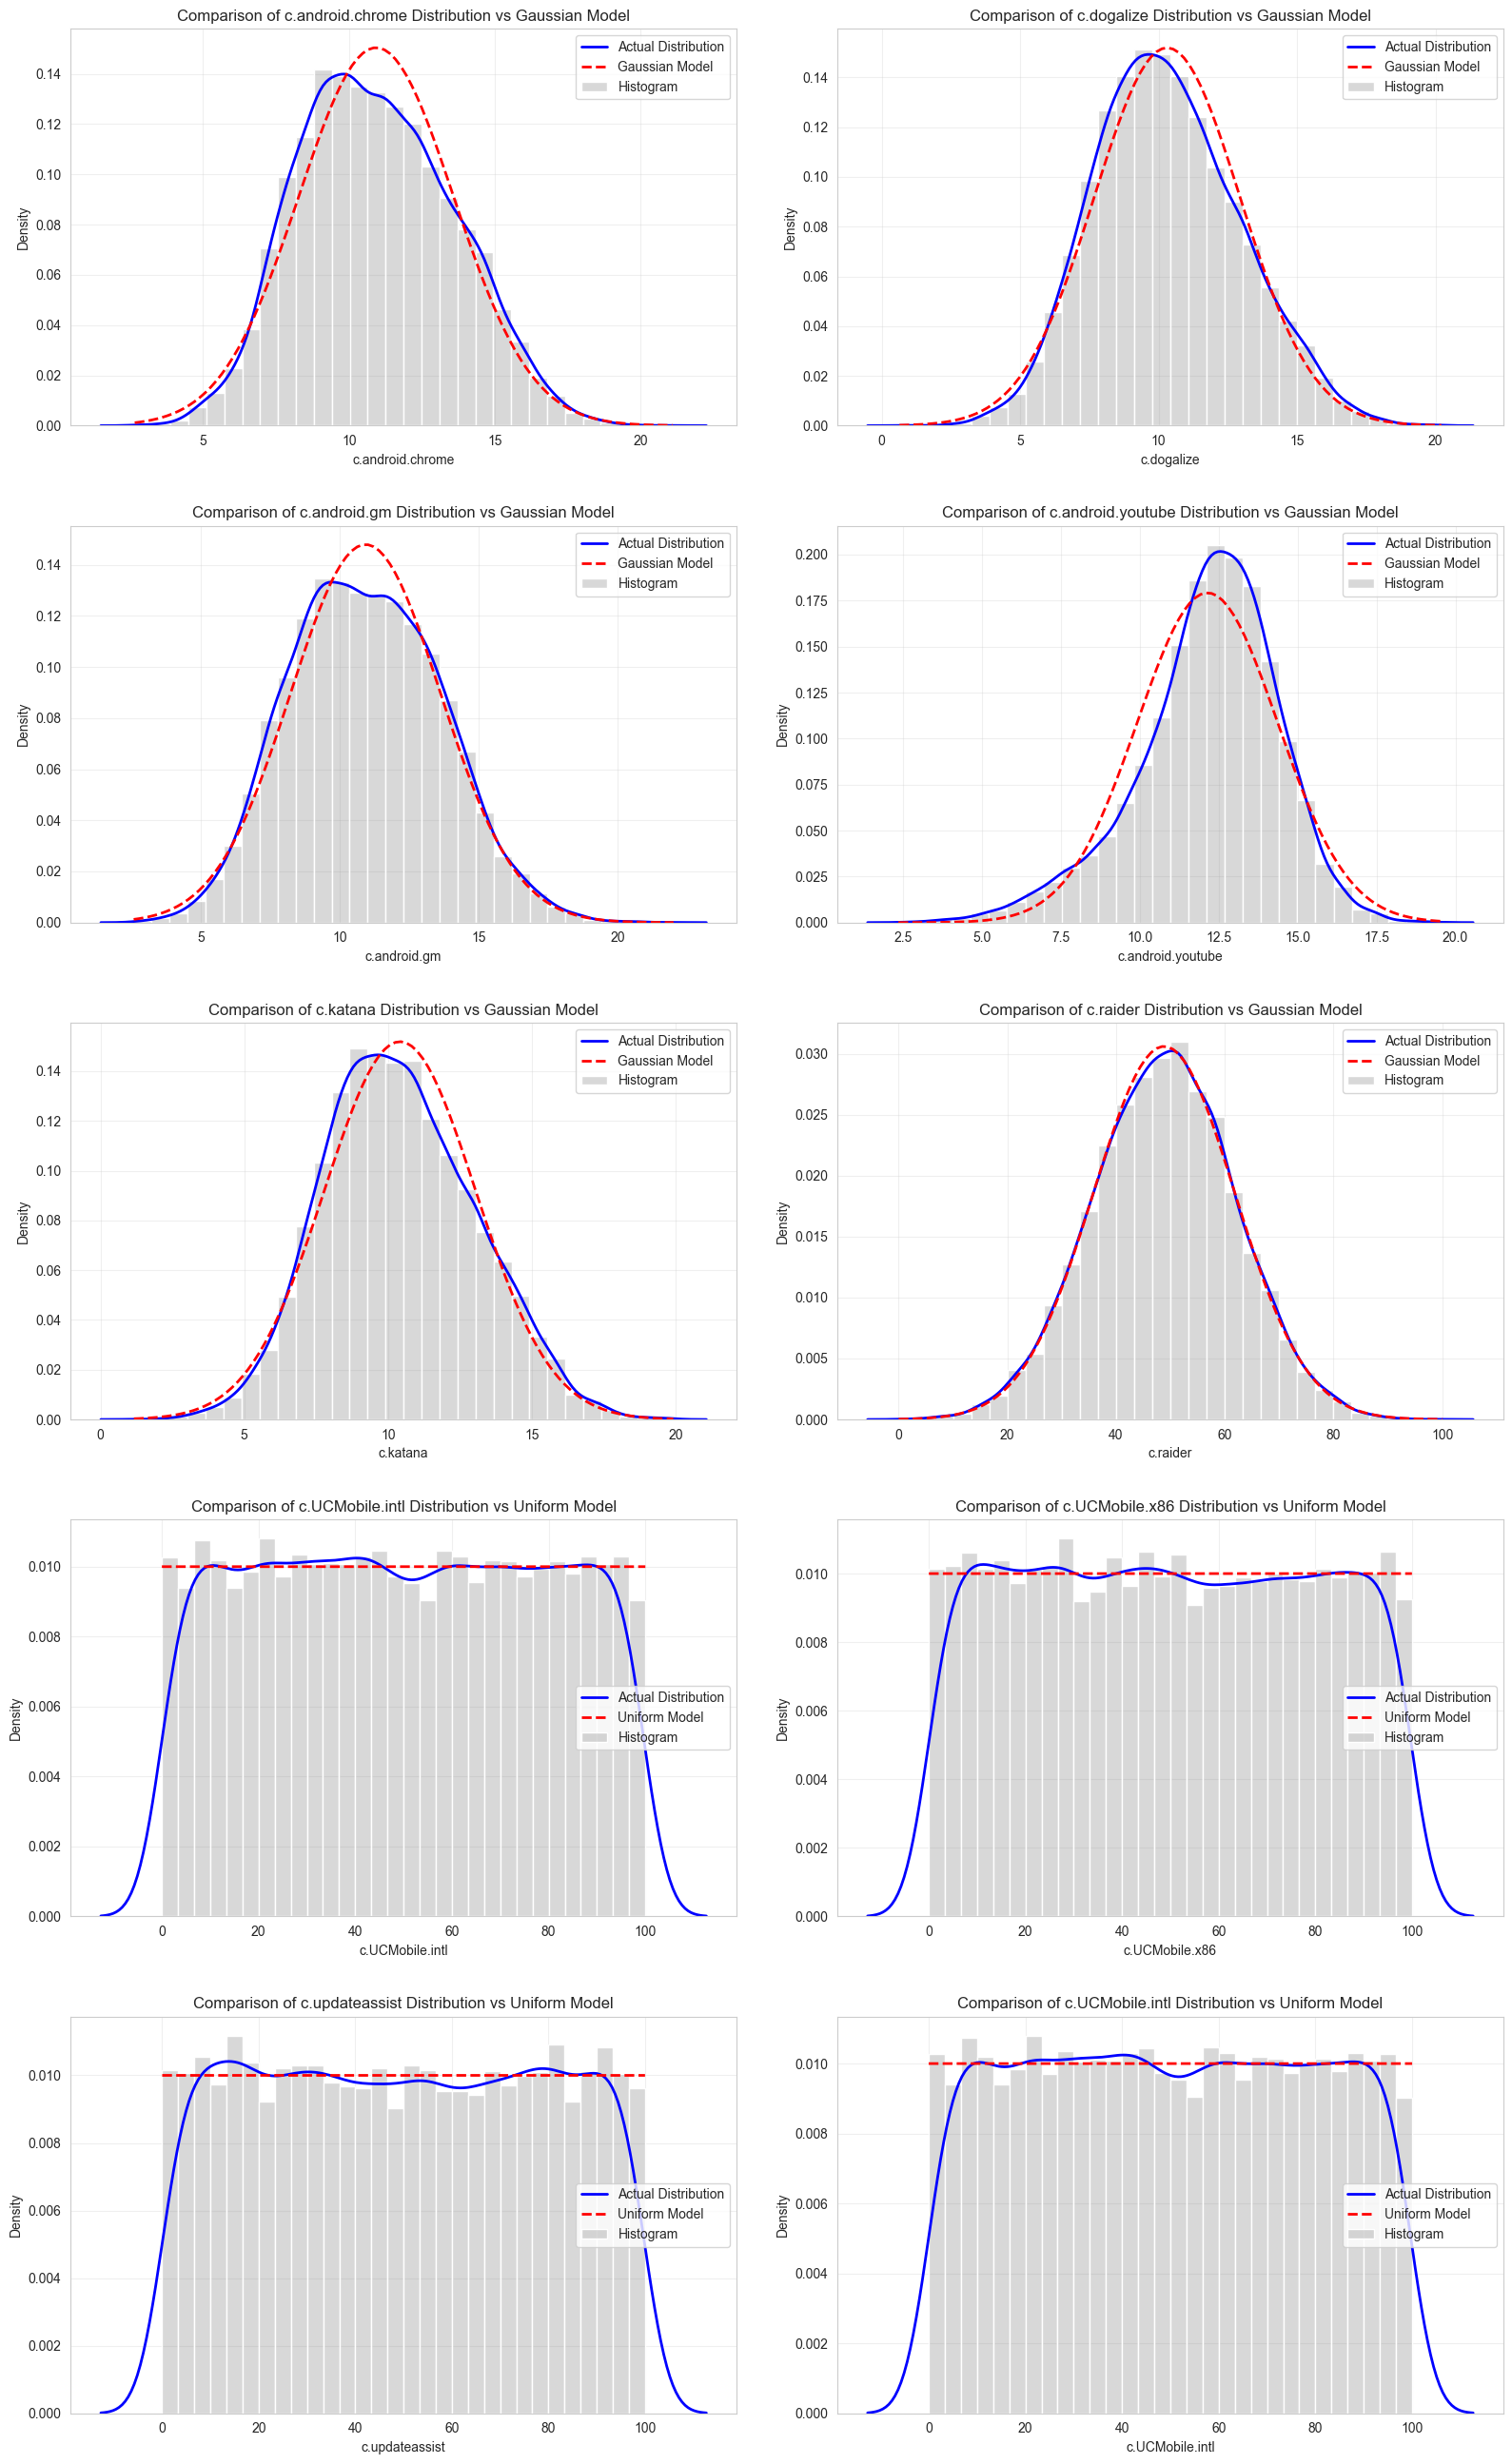

In [77]:
fig, axes = plt.subplots(5, 2, figsize=(16, 26))

# Chrome Data
sns.histplot(
    data=chrome_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[0, 0]
)
sns.kdeplot(data=chrome_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[0, 0])
x = np.linspace(chrome_data.min(), chrome_data.max(), 100)
gaussian = stats.norm.pdf(x, chrome_mean, chrome_std)
axes[0, 0].plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)
axes[0, 0].set_title("Comparison of c.android.chrome Distribution vs Gaussian Model")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dogalize Data
sns.histplot(
    data=dogalize_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[0, 1]
)
sns.kdeplot(data=dogalize_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[0, 1])
x = np.linspace(dogalize_data.min(), dogalize_data.max(), 100)
gaussian = stats.norm.pdf(x, dogalize_mean, dogalize_std)
axes[0, 1].plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)
axes[0, 1].set_title("Comparison of c.dogalize Distribution vs Gaussian Model")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# GM Data
sns.histplot(data=gm_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[1, 0])
sns.kdeplot(data=gm_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[1, 0])
x = np.linspace(gm_data.min(), gm_data.max(), 100)
gaussian = stats.norm.pdf(x, gm_mean, gm_std)
axes[1, 0].plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)
axes[1, 0].set_title("Comparison of c.android.gm Distribution vs Gaussian Model")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Youtube Data
sns.histplot(
    data=youtube_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[1, 1]
)
sns.kdeplot(data=youtube_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[1, 1])
x = np.linspace(youtube_data.min(), youtube_data.max(), 100)
gaussian = stats.norm.pdf(x, youtube_mean, youtube_std)
axes[1, 1].plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)
axes[1, 1].set_title("Comparison of c.android.youtube Distribution vs Gaussian Model")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Katana Data
sns.histplot(
    data=katana_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[2, 0]
)
sns.kdeplot(data=katana_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[2, 0])
x = np.linspace(katana_data.min(), katana_data.max(), 100)
gaussian = stats.norm.pdf(x, katana_mean, katana_std)
axes[2, 0].plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)
axes[2, 0].set_title("Comparison of c.katana Distribution vs Gaussian Model")
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Raider Data
sns.histplot(
    data=raider_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[2, 1]
)
sns.kdeplot(data=raider_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[2, 1])
x = np.linspace(raider_data.min(), raider_data.max(), 100)
gaussian = stats.norm.pdf(x, raider_mean, raider_std)
axes[2, 1].plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)
axes[2, 1].set_title("Comparison of c.raider Distribution vs Gaussian Model")
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

# Vending Data
a = intl_data.min()
b = intl_data.max()
x = np.linspace(a, b, intl_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)
sns.histplot(
    data=intl_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[3, 0]
)
sns.kdeplot(data=intl_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[3, 0])
axes[3, 0].plot(x, uniform_dist.pdf(x), color="red", linestyle="--", label="Uniform Model", linewidth=2)
axes[3, 0].set_title("Comparison of c.UCMobile.intl Distribution vs Uniform Model")
axes[3, 0].legend()
axes[3, 0].grid(True, alpha=0.3)

# x86 Data
a = x86_data.min()
b = x86_data.max()
x = np.linspace(a, b, x86_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)
sns.histplot(
    data=x86_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[3, 1]
)
sns.kdeplot(data=x86_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[3, 1])
axes[3, 1].plot(x, uniform_dist.pdf(x), color="red", linestyle="--", label="Uniform Model", linewidth=2)
axes[3, 1].set_title("Comparison of c.UCMobile.x86 Distribution vs Uniform Model")
axes[3, 1].legend()
axes[3, 1].grid(True, alpha=0.3)

# Updateassist Data
a = updateassist_data.min()
b = updateassist_data.max()
x = np.linspace(a, b, updateassist_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)
sns.histplot(
    data=updateassist_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[4, 0]
)
sns.kdeplot(data=updateassist_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[4, 0])
axes[4, 0].plot(x, uniform_dist.pdf(x), color="red", linestyle="--", label="Uniform Model", linewidth=2)
axes[4, 0].set_title("Comparison of c.updateassist Distribution vs Uniform Model")
axes[4, 0].legend()
axes[4, 0].grid(True, alpha=0.3)

# intl Data
a = intl_data.min()
b = intl_data.max()
x = np.linspace(a, b, intl_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)
sns.histplot(
    data=intl_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram", ax=axes[4, 1]
)
sns.kdeplot(data=intl_data, color="blue", label="Actual Distribution", linewidth=2, ax=axes[4, 1])
axes[4, 1].plot(x, uniform_dist.pdf(x), color="red", linestyle="--", label="Uniform Model", linewidth=2)
axes[4, 1].set_title("Comparison of c.UCMobile.intl Distribution vs Uniform Model")
axes[4, 1].legend()
axes[4, 1].grid(True, alpha=0.3)

# Adjust the layout
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

In [83]:
apps = [
    "c.android.chrome",
    "c.dogalize",
    "c.android.gm",
    "c.android.youtube",
    "c.katana",
    "c.raider",
    "c.android.vending",
    "c.UCMobile.x86",
    "c.updateassist",
    "c.UCMobile.intl",
]

means = [
    chrome_mean,
    dogalize_mean,
    gm_mean,
    youtube_mean,
    katana_mean,
    raider_mean,
    vending_mean,
    x86_mean,
    updateassist_mean,
    intl_mean,
]

medians = [
    chrome_data.median(),
    dogalize_data.median(),
    gm_data.median(),
    youtube_data.median(),
    katana_data.median(),
    raider_data.median(),
    vending_data.median(),
    x86_data.median(),
    updateassist_data.median(),
    intl_data.median(),
]

max_values = []
most_occurring_values = []

value_counts = chrome_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = dogalize_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = gm_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = youtube_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = katana_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = raider_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = vending_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = x86_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = updateassist_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())

value_counts = intl_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())

for i in range(len(most_occurring_values)):
    most_occurring_values[i] = most_occurring_values[i][: min(3, len(most_occurring_values[i]))]


data = {
    "connection": apps,
    "mean": means,
    "median": medians,
    "mode_count": max_values,
    "mode_values": most_occurring_values,
}

df = pd.DataFrame(data)
df

,connection,mean,median,mode_count,mode_values
0,c.android.chrome,10.933567,10.780055,3,"[15.09277, 13.96247, 12.66087]"
1,c.dogalize,10.309496,10.154350,3,"[8.4362, 8.08643, 10.34456]"
2,c.android.gm,10.928002,10.844220,3,"[7.37316, 9.99788, 9.46395]"
3,c.android.youtube,12.141882,12.375635,3,"[14.20878, 13.29313, 12.68658]"
4,c.katana,10.416465,10.263805,3,"[11.87016, 13.43679, 11.03079]"
5,c.raider,48.846209,48.962015,3,"[60.99804, 48.39264]"
6,c.android.vending,49.482347,49.269510,2,"[38.08731, 34.79229, 32.50178]"
7,c.UCMobile.x86,49.685602,49.300740,2,"[47.83628, 76.1005, 37.45813]"
8,c.updateassist,49.822994,49.852925,2,"[65.22365, 55.65401, 66.5042]"
9,c.UCMobile.intl,49.805628,49.520235,2,"[69.34231, 40.47904, 3.54383]"


In [76]:
data = {
    "Connection": [
        "c.android.chrome",
        "c.dogalize",
        "c.android.gm",
        "c.android.youtube",
        "c.katana",
        "c.raider",
        "c.android.vending",
        "c.UCMobile.x86",
        "c.updateassist",
        "c.UCMobile.intl",
    ],
    "Skew": [
        stats.skew(chrome_data),
        stats.skew(dogalize_data),
        stats.skew(gm_data),
        stats.skew(youtube_data),
        stats.skew(katana_data),
        stats.skew(raider_data),
        stats.skew(vending_data),
        stats.skew(x86_data),
        stats.skew(updateassist_data),
        stats.skew(intl_data),
    ],
    "Kurtosis": [
        stats.kurtosis(chrome_data),
        stats.kurtosis(dogalize_data),
        stats.kurtosis(gm_data),
        stats.kurtosis(youtube_data),
        stats.kurtosis(katana_data),
        stats.kurtosis(raider_data),
        stats.kurtosis(vending_data),
        stats.kurtosis(x86_data),
        stats.kurtosis(updateassist_data),
        stats.kurtosis(intl_data),
    ],
}

df = pd.DataFrame(data)
df["Result skew"] = np.nan


def skewness_type(skew_value):
    if skew_value <= -1:
        return "Highly Negative Skew"
    elif skew_value <= -0.5:
        return "Moderately Negative Skew"
    elif skew_value <= 0.5:
        return "Approximately Symmetric"
    elif skew_value <= 1:
        return "Moderately Positive Skew"
    else:
        return "Highly Positive Skew"


def kurtosis_type(kurtosis_value):
    if kurtosis_value < -2:
        return "Highly Platykurtic"
    elif kurtosis_value < -1:
        return "Platykurtic"
    elif kurtosis_value < 1:
        return "Mesokurtic"
    elif kurtosis_value < 2:
        return "Leptokurtic"
    else:
        return "Highly Leptokurtic"


df["Result skew"] = df["Skew"].apply(skewness_type)
df

,Connection,Skew,Kurtosis,Result skew
0,c.android.chrome,0.202709,-0.402562,Approximately Symmetric
1,c.dogalize,0.238739,-0.157746,Approximately Symmetric
2,c.android.gm,0.145092,-0.284452,Approximately Symmetric
3,c.android.youtube,-0.617624,0.687939,Moderately Negative Skew
4,c.katana,0.210126,-0.189410,Approximately Symmetric
5,c.raider,-0.023362,-0.059577,Approximately Symmetric
6,c.android.vending,0.015750,-1.198576,Approximately Symmetric
7,c.UCMobile.x86,0.014363,-1.211366,Approximately Symmetric
8,c.updateassist,0.008036,-1.221742,Approximately Symmetric
9,c.UCMobile.intl,0.005795,-1.204259,Approximately Symmetric
